In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import pickle

In [3]:
with open('../data/CIFAR10/batches.meta', 'rb') as f:
    meta = pickle.load(f)
    
class_names = dict(zip(list(range(10)), meta['label_names']))

In [10]:
transform_list = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

train = datasets.CIFAR10('../data/CIFAR10/train', train=True, download=True, transform=transform_list)
test = datasets.CIFAR10('../data/CIFAR10/test', train=False, download=True, transform=transform_list)

Files already downloaded and verified
Files already downloaded and verified


In [11]:
trainset = torch.utils.data.DataLoader(train, batch_size=128, shuffle=True)
testset = torch.utils.data.DataLoader(test, batch_size=128, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

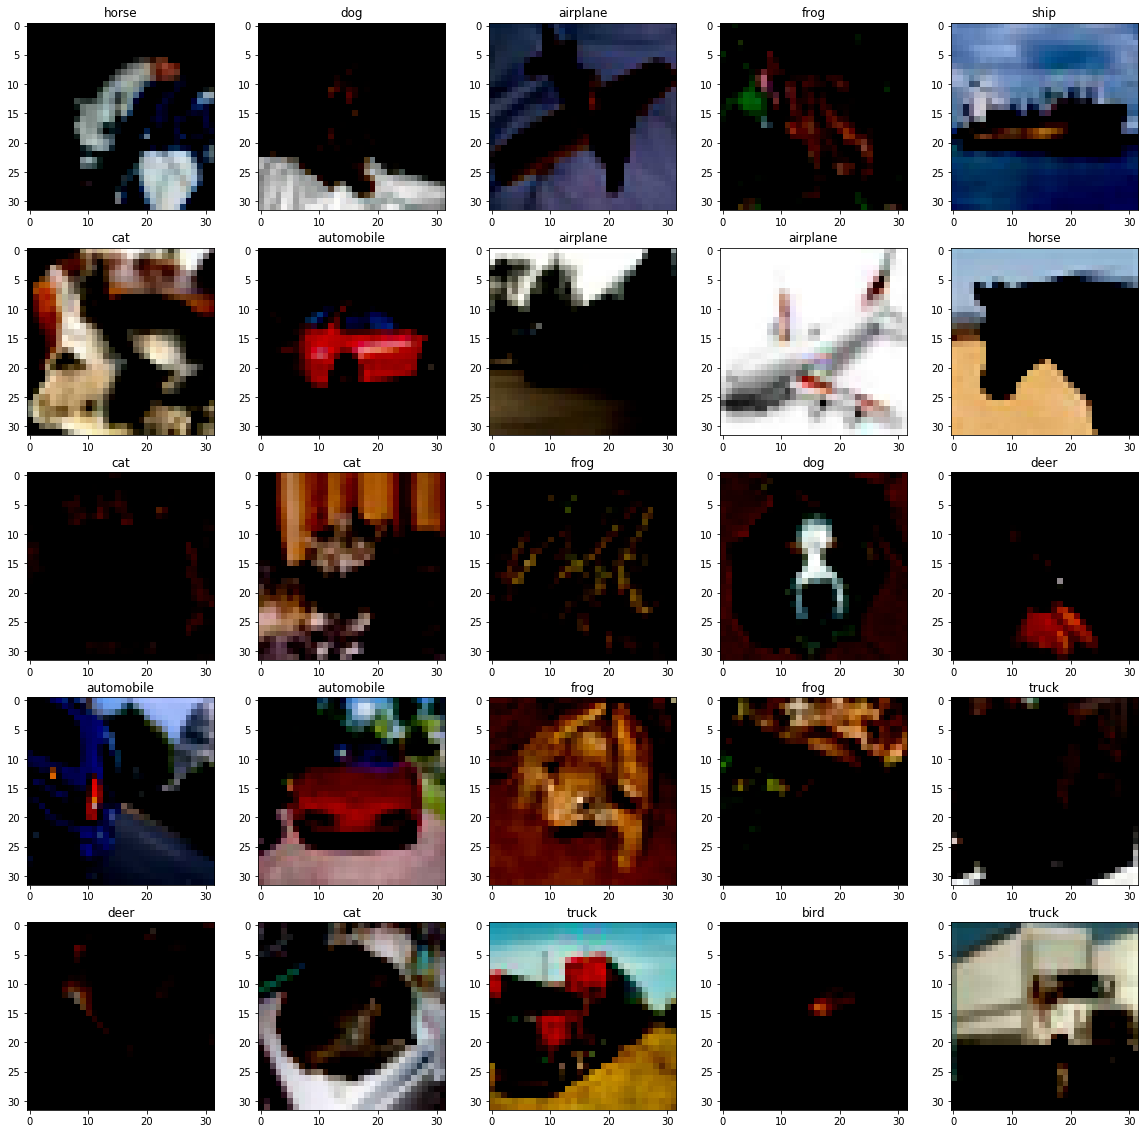

In [12]:
batch, labels = next(iter(trainset))

f = plt.figure(figsize=(20, 20))

for i in range(25):
    ax = f.add_subplot(5, 5, i+1)
    plt.imshow(batch[i].permute(1,2,0))
    plt.title(class_names[int(labels[i])])

In [15]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 16, (3, 3), padding=1)
        nn.init.kaiming_uniform_(self.conv1.weight)
        self.conv2 = nn.Conv2d(16, 32, (3, 3), padding=1)
        nn.init.kaiming_uniform_(self.conv2.weight)
        
        self.pool1 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.25)
        
        self.conv3 = nn.Conv2d(32, 32, (3, 3), padding=1)
        nn.init.kaiming_uniform_(self.conv3.weight)
        self.conv4 = nn.Conv2d(32, 64, (3, 3), padding=1)
        nn.init.kaiming_uniform_(self.conv4.weight)
        
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout2 = nn.Dropout(0.25)        
        
        self.fc1 = nn.Linear(64*8*8, 256)
        nn.init.kaiming_uniform_(self.fc1.weight)
        self.dropout3 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 10)
        nn.init.xavier_uniform_(self.fc2.weight)
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = torch.nn.LeakyReLU(0.1)(x)
        x = self.conv2(x)
        x = torch.nn.LeakyReLU(0.1)(x)
        x = self.pool1(x)
        x = self.dropout1(x)
        
        x = self.conv3(x)
        x = torch.nn.LeakyReLU(0.1)(x)
        x = self.conv4(x)
        x = torch.nn.LeakyReLU(0.1)(x)
        x = self.pool2(x)
        x = self.dropout2(x)
        
        x = x.view(-1, 64*8*8)
        
        x = self.fc1(x)
        x = nn.LeakyReLU(0.1)(x)
        x = self.dropout3(x)
        x = self.fc2(x)
        x = nn.Softmax(dim=1)(x)
        
        return x

In [32]:
def evaluate_accuracy_and_loss(model, testset):
    '''
    Evaluates both model accuracy and loss on a given dataset
    
    model - model to evaluate
    testset - dataset to evaluate model on
    
    Returns tuple (accuracy, mean loss)
    '''
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch in testset:
            images, labels = batch
            output = model(images.cuda())            
            for idx, i in enumerate(output):
                if torch.argmax(i) == labels[idx]:
                    correct += 1
                total += 1
                
    return correct/total

In [38]:
model = Model().cuda()
epochs = 20

optimizer = optim.Adam(model.parameters(), 1e-4)
criterion = nn.CrossEntropyLoss()

for e in range(epochs):
    
    model.train()
    
    for i, (batch, labels) in enumerate(trainset):
        
        optimizer.zero_grad()
        output = model(batch.cuda())
        
        loss = criterion(output, labels.cuda())
        loss.backward()
        
        optimizer.step()
        
        if i % 100 == 0:
            print('Step: %d, Loss: %.2f' % (i*100, loss))
        
    else:
        model.eval()
        print('Accuracy: %.2f' % evaluate_accuracy_and_loss(model, testset))

Step: 0, Loss: 2.33
Step: 10000, Loss: 2.22
Step: 20000, Loss: 2.14
Step: 30000, Loss: 2.20
Accuracy: 0.38
Step: 0, Loss: 2.11
Step: 10000, Loss: 2.09
Step: 20000, Loss: 2.05
Step: 30000, Loss: 2.07
Accuracy: 0.43
Step: 0, Loss: 2.07
Step: 10000, Loss: 2.05
Step: 20000, Loss: 2.08
Step: 30000, Loss: 1.99
Accuracy: 0.46
Step: 0, Loss: 2.00
Step: 10000, Loss: 2.04
Step: 20000, Loss: 2.04
Step: 30000, Loss: 1.95
Accuracy: 0.48
Step: 0, Loss: 2.02
Step: 10000, Loss: 2.00
Step: 20000, Loss: 2.01
Step: 30000, Loss: 1.96
Accuracy: 0.51
Step: 0, Loss: 1.99
Step: 10000, Loss: 1.95
Step: 20000, Loss: 1.91
Step: 30000, Loss: 1.96
Accuracy: 0.53
Step: 0, Loss: 1.93
Step: 10000, Loss: 1.92
Step: 20000, Loss: 1.91
Step: 30000, Loss: 1.97
Accuracy: 0.54
Step: 0, Loss: 1.97
Step: 10000, Loss: 1.93
Step: 20000, Loss: 1.94
Step: 30000, Loss: 1.98
Accuracy: 0.55
Step: 0, Loss: 1.85
Step: 10000, Loss: 1.99
Step: 20000, Loss: 1.90
Step: 30000, Loss: 1.90
Accuracy: 0.57
Step: 0, Loss: 1.93
Step: 10000, Loss